# Base Model

In [107]:
from PIL import Image
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import tensorflow as tf
import soundfile as sf
from keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [108]:
size = (1025, 430)

In [109]:
content_path = "data/input/NST/imperial.mp3"
style_path = "data/input/NST/usa.mp3"

In [110]:
x, sr = librosa.load(content_path)
display(Audio(x, rate=22050))
x, sr = librosa.load(style_path)
display(Audio(x, rate=22050))

In [111]:
def audio_to_img(path, size):
    x, sr = librosa.load(path)
    stft = librosa.stft(x)
    mag, phase = librosa.magphase(stft)
    mag = np.log1p(mag)

    mag_min, mag_max = mag.min(), mag.max()
    mag_norm = (mag - mag_min) / (mag_max - mag_min)

    mag_norm = mag_norm[:size[0], :size[1]]

    data = (mag_norm * 255).astype(np.uint8)
    img = Image.fromarray(data, mode='L')

    return img, mag_min, mag_max, phase

In [112]:
def image_to_audio(img, mag_min, mag_max):
    mag_norm = np.array(img, dtype=np.float32) / 255
    mag = mag_norm * (mag_max - mag_min) + mag_min
    mag = np.exp(mag) - 1
    return librosa.griffinlim(mag)

In [113]:
content_img, mag_min, mag_max, phase = audio_to_img(content_path, size)
style_img, _, _, _ = audio_to_img(style_path, size)

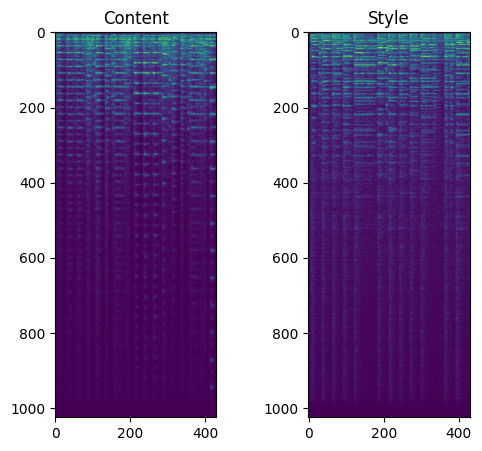

In [114]:
plt.figure(figsize=(6, 5))

plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(content_img)

plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(style_img)

plt.show()

In [115]:
content_np = np.array(content_img).T[None, None, :, :]
style_np = np.array(style_img).T[None, None, :, :]

content_tensor = tf.convert_to_tensor(content_np, dtype=tf.float32)
style_tensor = tf.convert_to_tensor(style_np, dtype=tf.float32)

In [116]:
BATCH, HEIGHT, WIDTH, CHANNELS = content_tensor.shape
FILTERS = 8192

input_shape = (HEIGHT, WIDTH, CHANNELS)

In [117]:
def custom_kernel_initializer(shape, dtype=None):
    std = np.sqrt(2) * np.sqrt(2.0 / ((CHANNELS + FILTERS) * 11))
    kernel = np.random.randn(1, 11, shape[-2], shape[-1]) * std
    return tf.constant(kernel, dtype=dtype)

In [118]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)

    outputs = Conv2D(
        filters=FILTERS,
        kernel_size=(1, 11),
        padding='same',
        activation='relu',
        kernel_initializer=custom_kernel_initializer
    )(inputs)

    return Model(inputs=inputs, outputs=outputs)

In [119]:
model = create_model(input_shape)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 1, 430, 1025)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1, 430, 8192)        │      92,372,992 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,372,992 (352.38 MB)

 Trainable params: 92,372,992 (352.38 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
def gram_matrix(x):
    feats = tf.reshape(x, (-1, x.shape[-1]))
    return tf.matmul(tf.transpose(feats), feats)

def get_style_loss(A, B):
    gram_A = gram_matrix(A)
    gram_B = gram_matrix(B)
    return tf.sqrt(tf.reduce_sum(tf.square(gram_A - gram_B)))

def get_content_loss(A, B):
    return tf.sqrt(tf.reduce_sum(tf.square(A - B)))

In [121]:
content_features = model(content_tensor)
style_features = model(style_tensor)

In [122]:
gen_np = tf.random.normal((1, *input_shape))
gen = tf.Variable(gen_np)

steps_counter = 0

In [123]:
STEPS = 2000
optimizer = Adam(learning_rate=1.0)

early_stop_patience = 50
tolerance = 1e-3

best_loss = float('inf')
patience_counter = 0

for i in range(STEPS):
    with tf.GradientTape() as tape:
        tape.watch(gen)

        gen_features = model(gen)

        content_loss = get_content_loss(gen_features, content_features)
        style_loss = get_style_loss(gen_features, style_features) * 0.001

        loss = content_loss + style_loss

    gradients = tape.gradient(loss, [gen])
    optimizer.apply_gradients(zip(gradients, [gen]))

    if loss.numpy() < best_loss - tolerance:
        best_loss = loss.numpy()
        patience_counter = 0
    else:
        patience_counter += 1

    if i % 50 == 0:
        print(f"Step: {i} | loss: {loss.numpy()} | content_loss: {content_loss.numpy()} | style_loss: {style_loss.numpy()}")

    if patience_counter >= early_stop_patience:
        print(f"Early stopping triggered at step {i}. No significant improvement.")
        break

steps_counter += i + 1


Step: 0 | loss: 951773.5625 | content_loss: 30287.6796875 | style_loss: 921485.875
Step: 50 | loss: 332170.90625 | content_loss: 26418.0859375 | style_loss: 305752.8125
Step: 100 | loss: 65343.3046875 | content_loss: 22847.642578125 | style_loss: 42495.66015625
Step: 150 | loss: 55422.3125 | content_loss: 20616.71484375 | style_loss: 34805.59765625
Step: 200 | loss: 42535.859375 | content_loss: 19421.47265625 | style_loss: 23114.384765625
Step: 250 | loss: 34171.4921875 | content_loss: 18504.314453125 | style_loss: 15667.1787109375
Step: 300 | loss: 29744.408203125 | content_loss: 17845.201171875 | style_loss: 11899.20703125
Step: 350 | loss: 27530.12890625 | content_loss: 17447.78125 | style_loss: 10082.3466796875
Step: 400 | loss: 26256.5703125 | content_loss: 17191.486328125 | style_loss: 9065.0830078125
Step: 450 | loss: 25483.181640625 | content_loss: 17019.421875 | style_loss: 8463.759765625
Step: 500 | loss: 24887.01171875 | content_loss: 16899.76171875 | style_loss: 7987.25
Ste

In [124]:
gen_np = np.squeeze(gen.numpy()).T
gen_img = Image.fromarray(gen_np).convert('L')

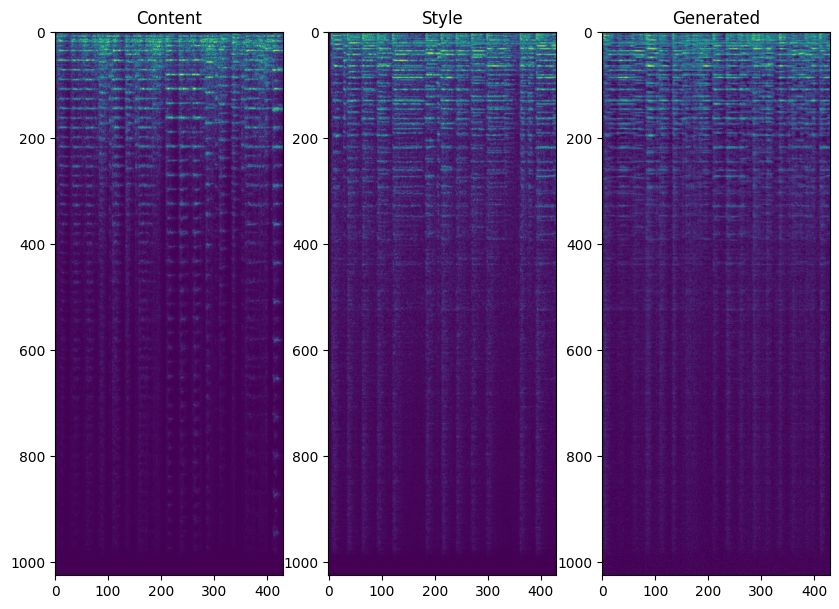

In [125]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.title("Content")
plt.imshow(content_img)

plt.subplot(1, 3, 2)
plt.title("Style")
plt.imshow(style_img)

plt.subplot(1, 3, 3)
plt.title("Generated")
plt.imshow(gen_img)

plt.show()

In [126]:
x = image_to_audio(gen_img, mag_min, mag_max)
display(Audio(x, rate=22050))

In [127]:
sf.write(f'data/output/NST/Tensorflow/v2_output.mp3', x, 22050)